# **Prepare datasets**

Kita akan memakai dataset NusaX dari paper [berikut](https://arxiv.org/pdf/2205.15960.pdf). Dataset bisa diunduh di [sini](https://drive.google.com/drive/folders/1z1V_dGuEgjZJ2RiauaEcGLkHjBMAwcuO?usp=sharing). Di dalamnya terdapat "train.csv", "valid.csv", dan "test.csv". 

Setelah kita download dataset, kita upload ke Google Colab. Setelah itu kita panggil dengan Pandas dan karena file nya terpisah, kita gabung menjadi 1. 

In [2]:
import pandas as pd

df = pd.read_csv('Data/Data training/train_preprocess.tsv', delimiter='\t')

In [2]:
df.shape

(10999, 2)

In [3]:
df.columns = ['text', 'label']

df.head()

,text,label
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive


In [4]:
df.label.value_counts()

label
positive    6415
negative    3436
neutral     1148
Name: count, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 10999 data. Terdiri dari:


*   Positive: 6415
*   Neutral: 3436
*   Negative: 1148



# **Text Normalization/Cleansing**

Lalu kita lakukan cleansing sebagai berikut,
1. Membuat fungsi stopwords removal, 
- Masukin stopwords removal jadi fungsi

In [5]:
import re 
import csv
# delete words/char
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every reTweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = text.strip() #menghapus spasi di awal dan akhir
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'(.)\1\1+', r'\1', text) #menghapus karakter berulang
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) #menghapus karakter non-alpanumerik
    text = re.sub(r'[øùºðµ¹ª³]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'â', 'a', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip() #menghapus spasi berlebih dan mengganti dengan satu spasi
    text = re.sub(r'^\s+$', '', text) #menghapus seluruh kalimat yg hanya berisi spasi
    text = re.sub(r'https\S+|[^a-zA-Z0-9]', ' ', text) # remove emoticon 
    return text

In [6]:
# Reduce words that start with /x
def remove_words_starting_with_x(text1):
    # Define a pattern to match words starting with \x
    pattern = re.compile(r'\b\\x\w*\b')
    
    # Replace the matched words with an empty string
    text = pattern.sub('', text1)
    
    return text

In [7]:
# func. kamus alay :
def replace_kamusalay(text1):
    # REPLACE TEXT
    replace_words = {}
    with open('Data/Data klasifikasi/new_kamusalay.csv', 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            replace_words[row[0]] = row[1]

    # Replace alay text 
    processed_text = text1  # Define processed_text before the loop
    for word, replacement in replace_words.items():
        processed_text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, processed_text)

    return processed_text

In [8]:
# Stopwords removal and Stemming words  
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stopwordsremoval_and_stemming(text):

     # Tokenize text
    freq_tokens = word_tokenize(text.lower())  # Convert text to lowercase for consistent comparison

    # Get Indonesian and English stopwords
    list_stopwords_id = list(set(stopwords.words('indonesian')))  # Convert set to list
    list_stopwords_en = list(set(stopwords.words('english')))     # Convert set to list

    # Extend the list with additional stopwords
    additional_stopwords = ['ya', 'yg', 'ga', 'yuk', 'dah', 'nya']
    list_stopwords_id.extend(additional_stopwords)

    # Combine Indonesian and English stopwords
    list_stopwords = list_stopwords_id + list_stopwords_en

    # Specify words to retain
    words_to_retain = ['tidak']  # Add more words as needed

    # Remove stopwords from the tokenized text, except words to retain
    tokens_without_stopword = [word for word in freq_tokens if word not in list_stopwords or word in words_to_retain]

    # STemming Indonesian only 
    stemmed_tokens = [stemmer.stem(token) for token in tokens_without_stopword]

    # Reconstruct the text without stopwords
    text_without_stopwords = ' '.join(stemmed_tokens)

    # print(text_without_stopwords)
    return text_without_stopwords

In [9]:
# ALL CLEANSING IN ONE FUNCTION 
# CLEANSING1 for model prediction 

def cleansing_model (data_input):

    text1 = data_input.lower()
    text1 = remove_unnecessary_char(text1)
    text1 = remove_words_starting_with_x(text1)
    text1 = replace_kamusalay(text1)
    text1 = stopwordsremoval_and_stemming(text1)

    return text1

In [10]:
# ngerun ini lama bisa 400-an menit
df['text_clean'] = df['text'].apply(cleansing_model)

In [11]:
#Hasilnya dimasukin biar akses selanjutnya gampang

import sqlite3

# Connect to the database
conn = sqlite3.connect('clean_data_training.db')

# Save the DataFrame to a database table
df.to_sql('Data_training_clean', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

In [4]:
# Langsung panggil dari database aja kl mau masuk ke model training <<<<<<<<<<<<<<<---------------------
# Run ini aja langsung <<-----
# Connect to the database
import sqlite3
conn = sqlite3.connect('clean_data_training.db')

# Execute a query and read the results into a DataFrame
query = "SELECT text_clean, label FROM Data_training_clean"
df_new = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [5]:
df_new

,text_clean,label
0,mohon ulama lurus k212 mmbri hujjah ai diwlh s...,neutral
1,lokasi strategis jalan sumatra bandung nyaman ...,positive
2,betapa bahagia unboxing paket barang bagus tet...,positive
3,aduh mahasiswa sombong kasih kakak kuning ajar...,negative
4,makan agam harga makan food stall 10 kasir sua...,positive
...,...,...
10994,tidak kecewa,positive
10995,enak masakan kepiting senang pilih kepiting se...,positive
10996,hormat ai ai koalisi,neutral
10997,pagi pagi tol pasteur macet parah bikin jengkel,negative


# **Feature Extraction: Bag of Words**

Setelah itu kita lakukan Feature Extraction menggunakan metode Bag of Words

In [6]:
# Kita simpan teks ke dalam sebuah variabel
data_preprocessed = df_new.text_clean.tolist()

In [7]:
data_preprocessed

['mohon ulama lurus k212 mmbri hujjah ai diwlh suara islam tidak pecah pecah',
 'lokasi strategis jalan sumatra bandung nyaman sofa lantai 2 paella enak pas makan minum bir dingin appetiser enak enak',
 'betapa bahagia unboxing paket barang bagus tetap beli',
 'aduh mahasiswa sombong kasih kakak kuning ajar tidak usah politik selesai kuliah politik tidak telat dasar mahasiswa',
 'makan agam harga makan food stall 10 kasir suasana ramai perhati parkir duduk',
 'pakai kakak kredit baca tidak untung rugi',
 'unik bagus foto makan enak pegawai ramah bersih luas wifi kencang harga standar sesuai menu masakan makan barat indonesia menu favorit lychee mojito spagheti',
 'keluarga nikmat alam kuliner senang rm sari sunda jalan setiabudhi bandung tidak hubung rm sari sunda jalan setiabudhi tulis maaf rekan rekan baca bingung suka restoran layan restoran bilang cepat',
 'syukur',
 'simcard indosat inaktiv gara gara lupa isi pulsa kabar aktif pinda pasca bayar ribet banget',
 'sifat iri muncul or

In [8]:
# Untuk melakukan Feature Extraction, kita menggunakan library "Sklearn atau scikit-learn".
# Sklearn adalah library untuk melakukan task-task Machine Learning.
# "CountVectorizer" merupakan salah satu modul untuk melakukan "BoW"

from sklearn.feature_extraction.text import CountVectorizer

# Kita proses Feature Extraction
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

X = count_vect.transform(data_preprocessed)
print ("Feature Extraction selesai")

Feature Extraction selesai


In [9]:
import pickle

pickle.dump(count_vect, open("feature_nn.p", "wb"))

# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [10]:
from sklearn.model_selection import train_test_split

classes = df_new.label

In [11]:
classes

0         neutral
1        positive
2        positive
3        negative
4        positive
           ...   
10994    positive
10995    positive
10996     neutral
10997    negative
10998    positive
Name: label, Length: 10999, dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size = 0.2)

# Training (Neural Network)

Jalankan training dengan metode Neural Network. "MLPClassifier" merupakan salah satu modul dari "Neural Network" pada library Sklearn.

In [13]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(verbose=True)
model.fit(X_train, y_train)

print ("Training selesai")

Iteration 1, loss = 0.71873543
Iteration 2, loss = 0.39438918
Iteration 3, loss = 0.27160435
Iteration 4, loss = 0.19779306
Iteration 5, loss = 0.15176422
Iteration 6, loss = 0.12104594
Iteration 7, loss = 0.09877390
Iteration 8, loss = 0.08299846
Iteration 9, loss = 0.07137191
Iteration 10, loss = 0.06211561
Iteration 11, loss = 0.05527254
Iteration 12, loss = 0.04951819
Iteration 13, loss = 0.04472400
Iteration 14, loss = 0.04091687
Iteration 15, loss = 0.03736963
Iteration 16, loss = 0.03469196
Iteration 17, loss = 0.03200111
Iteration 18, loss = 0.02968271
Iteration 19, loss = 0.02763214
Iteration 20, loss = 0.02567377
Iteration 21, loss = 0.02384771
Iteration 22, loss = 0.02229971
Iteration 23, loss = 0.02089398
Iteration 24, loss = 0.01947486
Iteration 25, loss = 0.01822057
Iteration 26, loss = 0.01700058
Iteration 27, loss = 0.01592262
Iteration 28, loss = 0.01487001
Iteration 29, loss = 0.01391364
Iteration 30, loss = 0.01298010
Iteration 31, loss = 0.01215377
Iteration 32, los

In [14]:
pickle.dump(model, open("model_nn.p", "wb"))

# **Evaluation**

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [15]:
from sklearn.metrics import classification_report

test = model.predict(X_test)

print ("Testing selesai")

print(classification_report(y_test, test)) 

Testing selesai
              precision    recall  f1-score   support

    negative       0.76      0.80      0.78       685
     neutral       0.73      0.58      0.65       241
    positive       0.88      0.89      0.88      1274

    accuracy                           0.83      2200
   macro avg       0.79      0.76      0.77      2200
weighted avg       0.83      0.83      0.83      2200



Hasilnya nilai F1 Score ada pada angka 0.81 untuk Negative, 0.68 untuk Neutral, dan 0.86 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model.

## **Cross Validation**

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

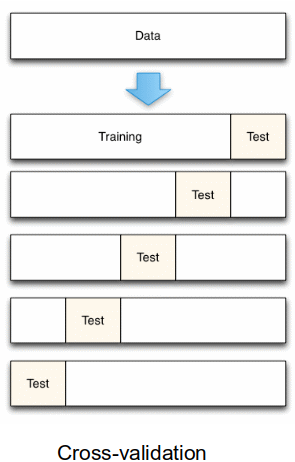

In [16]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# n_splits bisa dikurangin biar ga panjang, ini 5 split butuh 155 menit
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = classes

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    clf = MLPClassifier()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # for the current fold only    
    accuracy = accuracy_score(target_test,preds)

    print("Training ke-", iteration)
    print(classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76       693
     neutral       0.66      0.65      0.66       213
    positive       0.88      0.88      0.88      1294

    accuracy                           0.82      2200
   macro avg       0.77      0.76      0.76      2200
weighted avg       0.82      0.82      0.82      2200

Training ke- 2
              precision    recall  f1-score   support

    negative       0.77      0.77      0.77       729
     neutral       0.80      0.58      0.67       247
    positive       0.86      0.90      0.88      1224

    accuracy                           0.82      2200
   macro avg       0.81      0.75      0.77      2200
weighted avg       0.82      0.82      0.82      2200

Training ke- 3
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       689
     neutral       0.72      0.58      0.64       216
    positive       0.87      0

Hasilnya nilai rata-rata accuracy pada angka 0.77. Ini menunjukkan model kita cukup stabil pada angka 0.77.

# Predict

Asumsi kita sudah oke dengan model yang dibikin, selanjutnya melakukan predict pada model untuk mengetes jika model sudah jalan.

Kita test pakai unseen data

In [17]:
data_test = pd.read_csv('Data unseen/data.csv')
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [20]:
# CHANGING INTO Lower Case Tweet
def lowercase(text):
    return text.lower()

# delete words/char
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    return text

# Reduce words that start with /x
def remove_words_starting_with_x(text1):
    # Define a pattern to match words starting with \x
    pattern = re.compile(r'\b\\x\w*\b')
    
    # Replace the matched words with an empty string
    text = pattern.sub('', text1)
    
    return text

# ALL CLEANSING IN ONE FUNC 
def cleansing(data_input):
    
# REMOVE ABUSIVE WORDS
    with open('Data/Data klasifikasi/abusive.csv', 'r') as csv_file:
        remove_words = [row[0] for row in csv.reader(csv_file)]    
    ## Escape special characters in the words
    remove_words_escaped = [re.escape(word) for word in remove_words]
    ## Create a pattern to match common emoticons and specific words to remove
    pattern_to_remove = re.compile('|'.join(remove_words_escaped))

    text1 = lowercase(data_input)
    text1 = remove_unnecessary_char(text1)
    text1 = remove_words_starting_with_x(text1)
    
# Remove emoticons
    processed_text = re.sub(r'https\S+|[^a-zA-Z0-9]', ' ', text1)

# REPLACE TEXT
    replace_words = {}
    with open('Data/Data klasifikasi/new_kamusalay.csv', 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            replace_words[row[0]] = row[1]

    ## Replace alay text 
    for word, replacement in replace_words.items():
        processed_text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, processed_text)
# Remove abusive words from the text 
    processed_text = re.sub(pattern_to_remove, ' ', processed_text).strip()
# Remove extraspace
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

In [27]:
# CLEANSING for API -- CLAIRE

import re 

alay_dict = pd.read_csv('Data/Data klasifikasi/new_kamusalay.csv', names = ['original', 'replacement'], encoding='latin-1')
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove abusive words from text
abusive_dict = pd.read_csv('Data/Data klasifikasi/abusive.csv', names = ['original', 'replacement'], encoding='latin-1')
abusive_dict_map = dict(zip(abusive_dict['original'], abusive_dict['replacement']))
def remove_abusive(text):
    return ' '.join([abusive_dict_map[word] if word in abusive_dict_map else word for word in text.split(' ')])


df=pd.read_csv('Data/Data klasifikasi/abusive.csv')

bannedWord = df["ABUSIVE"].values.tolist()

def RemoveBannedWords(toPrint,database):
    statement = toPrint
    database_1 = sorted(list(database), key=len)
    pattern = re.compile(r"\b(" + "|".join(database_1) + ")\\W", re.I)
    return pattern.sub("", toPrint + ' ')[:-1] #added because it skipped last word


def cleansing_cl(data_input):

    text_clean = normalize_alay(data_input)
    text_clean = RemoveBannedWords(text_clean,bannedWord)

    return text_clean

In [28]:
# cara 1: cara manual
# original_text =  '''
# deklarasi pilkada 2018 aman dan anti hoax warga dukuh sari jabo
# '''

# cara2: cara pake unseen data dari gold challenge
input_form = data_test['Tweet'][4]

# Feature Extraction
# temen2 bisa lakukn cleansing regex yang ada di gold challenge
text = count_vect.transform([cleansing_cl(input_form)])
# cleansing 

# Kita prediksi sentimennya
result = model.predict(text)[0]
print("Sentiment:")
print()
print(result)

print("=================================")
print("sebelum cleansing:", input_form)
print("setelah cleansing:", cleansing_cl(input_form))

Sentiment:

positive
sebelum cleansing: USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'
setelah cleansing: USER USER Kaum sudah kelihatan dongoknya dari awal tambah lagi hahahah'
